# P300 Speller with SVM

Here we begin by importing all the important libraries and by loading the pre-processed data in MatLab. The data are signals from the P300 Speller experiment described in the GitHub page. We have 5 different pre-processed data from 5 different patients. 

The task is to build a ML model that help to predict whether the signal is part of a visual stimulus or not:

- 1 is the signal is part of the stimulus;
- -1 otherwise.

In addition, we separated the data in two different categories:

- odb: the data where the label is 1;
- std: the data where the label is -1.

In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import pandas as pd
import math

from scipy.io import loadmat
import scipy.io as sio
import seaborn as sns
import sklearn

from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit, cross_val_score

import keras
from keras import Sequential
from keras.layers import *
from keras.callbacks import *

import tensorflow as tf

In [2]:
odb_1 = scipy.io.loadmat('data/P1_odb_down.mat')
std_1 = scipy.io.loadmat('data/P1_std_down.mat')

odb_2 = scipy.io.loadmat('data/P2_odb_down.mat')
std_2 = scipy.io.loadmat('data/P2_std_down.mat')

odb_3 = scipy.io.loadmat('data/P3_odb_down.mat')
std_3 = scipy.io.loadmat('data/P3_std_down.mat')

odb_4 = scipy.io.loadmat('data/P4_odb_down.mat')
std_4 = scipy.io.loadmat('data/P4_std_down.mat')

odb_5 = scipy.io.loadmat('data/P5_odb_down.mat')
std_5 = scipy.io.loadmat('data/P5_std_down.mat')

## Processing Data

We take only the part of the data we will work with. The ".mat" files are like a dictionary, so we need to extract just the part with the data.

In [3]:
X_std_1 = std_1['E_std_down']
X_odb_1 = odb_1['E_odb_down']

X_std_2 = std_2['E_std_down']
X_odb_2 = odb_2['E_odb_down']

X_std_3 = std_3['E_std_down']
X_odb_3 = odb_3['E_odb_down']

X_std_4 = std_4['E_std_down']
X_odb_4 = odb_4['E_odb_down']

X_std_5 = std_5['E_std_down']
X_odb_5 = odb_5['E_odb_down']

Creating dataframes can help to better handle the data.

In [4]:
data_std_1 = pd.DataFrame(X_std_1)
data_odb_1 = pd.DataFrame(X_odb_1)

data_std_2 = pd.DataFrame(X_std_2)
data_odb_2 = pd.DataFrame(X_odb_2)

data_std_3 = pd.DataFrame(X_std_3)
data_odb_3 = pd.DataFrame(X_odb_3)

data_std_4 = pd.DataFrame(X_std_4)
data_odb_4 = pd.DataFrame(X_odb_4)

data_std_5 = pd.DataFrame(X_std_5)
data_odb_5 = pd.DataFrame(X_odb_5)

We created the label vectors:

In [5]:
data_odb_1['y'] = np.ones((150))
data_std_1['y'] = np.ones((1050))*(-1)

data_odb_2['y'] = np.ones((150))
data_std_2['y'] = np.ones((1050))*(-1)

data_odb_3['y'] = np.ones((150))
data_std_3['y'] = np.ones((1050))*(-1)

data_odb_4['y'] = np.ones((150))
data_std_4['y'] = np.ones((1050))*(-1)

data_odb_5['y'] = np.ones((150))
data_std_5['y'] = np.ones((1050))*(-1)

## Imbalanced Dataset

Since the dataset is imbalanced, we decided to downsample the data and take the same amount of value from the std data.

In [6]:
data_1 = pd.concat([data_odb_1,data_std_1[:150]])

data_2 = pd.concat([data_odb_2,data_std_2[:150]])

data_3 = pd.concat([data_odb_3,data_std_3[:150]])

data_4 = pd.concat([data_odb_4,data_std_4[:150]])

data_5 = pd.concat([data_odb_5,data_std_5[:150]])

Here we reshuffle the dataframe to avoid making the model learn a deterministic pattern.

In [7]:
data_1 = data_1.sample(frac=1, random_state=0)

data_2 = data_2.sample(frac=1, random_state=0)

data_3 = data_3.sample(frac=1, random_state=0)

data_4 = data_4.sample(frac=1, random_state=0)

data_5 = data_5.sample(frac=1, random_state=0)

And we created the X and y data as array to perform the last modification.

In [8]:
X_1 = data_1.loc[:, data_1.columns != 'y'].to_numpy()
y_1 = data_1['y'].to_numpy()

X_2 = data_2.loc[:, data_2.columns != 'y'].to_numpy()
y_2 = data_2['y'].to_numpy()

X_3 = data_3.loc[:, data_3.columns != 'y'].to_numpy()
y_3 = data_3['y'].to_numpy()

X_4 = data_4.loc[:, data_4.columns != 'y'].to_numpy()
y_4 = data_4['y'].to_numpy()

X_5 = data_5.loc[:, data_5.columns != 'y'].to_numpy()
y_5 = data_5['y'].to_numpy()

## Standardized Data

Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise standardized (μ=0, σ=1) is usually used prior to model fitting. Here there is the standardization:

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_1_std = scaler.fit_transform(X_1)

X_2_std = scaler.fit_transform(X_2)

X_3_std = scaler.fit_transform(X_3)

X_4_std = scaler.fit_transform(X_4)

X_5_std = scaler.fit_transform(X_5)

## Train-Test Split and X_train, y_train creation

We train-test split and create the X_train and y_train we will use to train the model. The last part is to reshuffle the data.

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [11]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1_std, y_1,
                                                            test_size=0.1, stratify=y_1, random_state=42)

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2_std, y_2,
                                                            test_size=0.1, stratify=y_2, random_state=42)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3_std, y_3,
                                                            test_size=0.1, stratify=y_3, random_state=42)

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4_std, y_4,
                                                            test_size=0.1, stratify=y_4, random_state=42)

X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_5_std, y_5,
                                                            test_size=0.1, stratify=y_5, random_state=42)

We create the train as the union of the all train data from the 5 different patients.

In [12]:
X_train = np.vstack((X_train_1,X_train_2,X_train_3,X_train_4))
y_train = np.hstack((y_train_1,y_train_2,y_train_3,y_train_4))

And this is the last part were we shuffle the data to avoid other deterministic pattern.

In [13]:
data = pd.DataFrame(X_train)
data['y'] = y_train
data.head()

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,y
0,1.430836,1.078124,0.325472,-0.257132,-0.678663,-1.266310,-1.131225,-0.114271,1.526363,0.230417,...,-0.374042,0.428108,0.494919,0.541443,-0.625490,-0.046604,-0.005975,-0.648095,0.017793,1.0
1,0.404253,-0.664945,-0.812230,-0.418725,-0.436707,-0.200638,0.550109,1.609472,0.207669,0.784649,...,0.664110,-0.339470,0.733363,-1.184289,1.472521,0.987418,-0.499976,-0.385905,-0.487583,-1.0
2,-1.109324,-0.849852,0.445107,0.032421,-0.723345,0.960236,-0.041948,-0.699620,-0.792444,0.439816,...,-1.562043,0.268086,0.118605,0.439580,1.133079,0.712399,0.077000,-0.729052,-0.249662,-1.0
3,0.768406,0.479360,0.861883,0.779610,1.291613,0.045876,-0.150509,-0.158907,0.350779,-0.708267,...,0.387941,0.621212,-1.040548,-0.805404,-0.402308,-1.201806,0.863859,-0.239232,1.206397,1.0
4,0.387547,0.631630,0.273774,0.049799,-0.789375,0.273200,-0.081125,0.245377,0.484055,-0.470547,...,0.725006,1.245003,-0.203622,1.180171,-0.645822,0.564838,-0.317559,-0.571817,0.630544,1.0


In [14]:
data = data.sample(frac=1, random_state=0)

In [15]:
X_train = data.loc[:, data.columns != 'y'].to_numpy()
y_train = data['y'].to_numpy()

## Autoencoder

Here we tried to use an autoencoder to have a feature embedding. The results are quite good.

In [16]:
model = Sequential([Dense(136, activation = 'relu'),
Dense(1000, activation = 'relu'),
Dense(500, activation = 'relu'),
Dense(200, activation = 'relu'),
Dense(136, activation = 'relu', name = 'encoder'),
Dense(200, activation = 'relu'),
Dense(500, activation = 'relu'),
Dense(1000, activation = 'relu'),
Dense(136)])

opt = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam")


model.compile(optimizer=opt,
              loss='mean_squared_error',
              metrics=['mae','acc'])

earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=25, verbose=0, mode='min')
mcp_save = ModelCheckpoint('.mdl_wts.hdf5',
                           save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.1, patience=7,
                                   verbose=1, epsilon=1e-4, mode='min')

history = model.fit(X_train, X_train, epochs = 1000,
                    batch_size = 256, verbose = 1) #callbacks=[earlyStopping],

Epoch 1/1000
5/5 [==============================] - 2s 24ms/step - loss: 0.9876 - mae: 0.7551 - acc: 0.0085
Epoch 2/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.8245 - mae: 0.6920 - acc: 0.0264
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7088 - mae: 0.6420 - acc: 0.0257
Epoch 4/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.6090 - mae: 0.5981 - acc: 0.0344
Epoch 5/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.5666 - mae: 0.5720 - acc: 0.0326
Epoch 6/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.5210 - mae: 0.5505 - acc: 0.0478
Epoch 7/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.5010 - mae: 0.5374 - acc: 0.0468
Epoch 8/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.4742 - mae: 0.5233 - acc: 0.0601
Epoch 9/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.4553 - mae: 0.5109 - acc: 0.0750
Epoch 10/1000
5/5 [=========

5/5 [==============================] - 0s 14ms/step - loss: 0.0811 - mae: 0.2217 - acc: 0.4897
Epoch 76/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0820 - mae: 0.2238 - acc: 0.4916
Epoch 77/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0781 - mae: 0.2183 - acc: 0.4758
Epoch 78/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0750 - mae: 0.2137 - acc: 0.4923
Epoch 79/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0755 - mae: 0.2145 - acc: 0.5027
Epoch 80/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0718 - mae: 0.2095 - acc: 0.4966
Epoch 81/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0742 - mae: 0.2129 - acc: 0.5228
Epoch 82/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0719 - mae: 0.2099 - acc: 0.5145
Epoch 83/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0718 - mae: 0.2098 - acc: 0.5473
Epoch 84/1000
5/5 [==============

5/5 [==============================] - 0s 14ms/step - loss: 0.0251 - mae: 0.1250 - acc: 0.6847
Epoch 150/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0237 - mae: 0.1213 - acc: 0.6693
Epoch 151/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0231 - mae: 0.1198 - acc: 0.6990
Epoch 152/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0214 - mae: 0.1152 - acc: 0.7073
Epoch 153/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0230 - mae: 0.1195 - acc: 0.7048
Epoch 154/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0271 - mae: 0.1297 - acc: 0.6864
Epoch 155/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0242 - mae: 0.1227 - acc: 0.7007
Epoch 156/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0246 - mae: 0.1236 - acc: 0.6894
Epoch 157/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0256 - mae: 0.1261 - acc: 0.6981
Epoch 158/1000
5/5 [=====

5/5 [==============================] - 0s 16ms/step - loss: 0.0115 - mae: 0.0847 - acc: 0.7804
Epoch 224/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0134 - mae: 0.0915 - acc: 0.7777
Epoch 225/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0149 - mae: 0.0965 - acc: 0.7855
Epoch 226/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0130 - mae: 0.0896 - acc: 0.7729
Epoch 227/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.0121 - mae: 0.0866 - acc: 0.7989
Epoch 228/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0117 - mae: 0.0853 - acc: 0.8087
Epoch 229/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0108 - mae: 0.0819 - acc: 0.7967
Epoch 230/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0098 - mae: 0.0782 - acc: 0.8172
Epoch 231/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0095 - mae: 0.0768 - acc: 0.8275
Epoch 232/1000
5/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 0.0132 - mae: 0.0900 - acc: 0.7801
Epoch 298/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0128 - mae: 0.0884 - acc: 0.8207
Epoch 299/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0112 - mae: 0.0827 - acc: 0.8165
Epoch 300/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0112 - mae: 0.0830 - acc: 0.8160
Epoch 301/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0100 - mae: 0.0784 - acc: 0.8349
Epoch 302/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0096 - mae: 0.0768 - acc: 0.8239
Epoch 303/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0106 - mae: 0.0811 - acc: 0.8358
Epoch 304/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0085 - mae: 0.0725 - acc: 0.8117
Epoch 305/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - mae: 0.0705 - acc: 0.8266
Epoch 306/1000
5/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 0.0088 - mae: 0.0736 - acc: 0.8178
Epoch 372/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0091 - mae: 0.0743 - acc: 0.8256
Epoch 373/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0079 - mae: 0.0692 - acc: 0.8370
Epoch 374/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0080 - mae: 0.0698 - acc: 0.8412
Epoch 375/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0072 - mae: 0.0665 - acc: 0.8526
Epoch 376/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0068 - mae: 0.0645 - acc: 0.8493
Epoch 377/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0072 - mae: 0.0663 - acc: 0.8470
Epoch 378/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0074 - mae: 0.0677 - acc: 0.8495
Epoch 379/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0069 - mae: 0.0653 - acc: 0.8516
Epoch 380/1000
5/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 0.0076 - mae: 0.0677 - acc: 0.8509
Epoch 446/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0065 - mae: 0.0627 - acc: 0.8697
Epoch 447/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0083 - mae: 0.0704 - acc: 0.8409
Epoch 448/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0066 - mae: 0.0630 - acc: 0.8575
Epoch 449/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0081 - mae: 0.0696 - acc: 0.8481
Epoch 450/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0089 - mae: 0.0734 - acc: 0.8317
Epoch 451/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0106 - mae: 0.0803 - acc: 0.8324
Epoch 452/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0108 - mae: 0.0809 - acc: 0.8172
Epoch 453/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0093 - mae: 0.0748 - acc: 0.8130
Epoch 454/1000
5/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 0.0040 - mae: 0.0488 - acc: 0.8727
Epoch 520/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0036 - mae: 0.0464 - acc: 0.8949
Epoch 521/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0033 - mae: 0.0444 - acc: 0.8976
Epoch 522/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0032 - mae: 0.0439 - acc: 0.9133
Epoch 523/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0036 - mae: 0.0468 - acc: 0.8951
Epoch 524/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0033 - mae: 0.0442 - acc: 0.8842
Epoch 525/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0035 - mae: 0.0458 - acc: 0.8908
Epoch 526/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0033 - mae: 0.0445 - acc: 0.9095
Epoch 527/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0062 - mae: 0.0609 - acc: 0.8793
Epoch 528/1000
5/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 0.0080 - mae: 0.0690 - acc: 0.8538
Epoch 594/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0066 - mae: 0.0630 - acc: 0.8532
Epoch 595/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0062 - mae: 0.0614 - acc: 0.8549
Epoch 596/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0067 - mae: 0.0637 - acc: 0.8539
Epoch 597/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0064 - mae: 0.0622 - acc: 0.8630
Epoch 598/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0061 - mae: 0.0607 - acc: 0.8602
Epoch 599/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0062 - mae: 0.0612 - acc: 0.8685
Epoch 600/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0071 - mae: 0.0655 - acc: 0.8589
Epoch 601/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0063 - mae: 0.0620 - acc: 0.8746
Epoch 602/1000
5/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 0.0057 - mae: 0.0587 - acc: 0.8816
Epoch 668/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0052 - mae: 0.0555 - acc: 0.8709
Epoch 669/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0073 - mae: 0.0648 - acc: 0.8808
Epoch 670/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0135 - mae: 0.0909 - acc: 0.8249
Epoch 671/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0114 - mae: 0.0832 - acc: 0.8203
Epoch 672/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0098 - mae: 0.0769 - acc: 0.8205
Epoch 673/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0125 - mae: 0.0866 - acc: 0.8111
Epoch 674/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0122 - mae: 0.0858 - acc: 0.8213
Epoch 675/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0123 - mae: 0.0864 - acc: 0.8242
Epoch 676/1000
5/5 [=====

5/5 [==============================] - 0s 15ms/step - loss: 0.0026 - mae: 0.0394 - acc: 0.9225
Epoch 742/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0031 - mae: 0.0432 - acc: 0.9154
Epoch 743/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0034 - mae: 0.0448 - acc: 0.9064
Epoch 744/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0035 - mae: 0.0465 - acc: 0.8959
Epoch 745/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0051 - mae: 0.0557 - acc: 0.8878
Epoch 746/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.0049 - mae: 0.0549 - acc: 0.8898
Epoch 747/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0055 - mae: 0.0576 - acc: 0.8946
Epoch 748/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0061 - mae: 0.0603 - acc: 0.8856
Epoch 749/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0117 - mae: 0.0840 - acc: 0.8379
Epoch 750/1000
5/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 3.8456e-04 - mae: 0.0152 - acc: 0.9670
Epoch 815/1000
5/5 [==============================] - 0s 14ms/step - loss: 4.1986e-04 - mae: 0.0160 - acc: 0.9650
Epoch 816/1000
5/5 [==============================] - 0s 14ms/step - loss: 4.0709e-04 - mae: 0.0159 - acc: 0.9626
Epoch 817/1000
5/5 [==============================] - 0s 14ms/step - loss: 4.1043e-04 - mae: 0.0159 - acc: 0.9581
Epoch 818/1000
5/5 [==============================] - 0s 14ms/step - loss: 4.1989e-04 - mae: 0.0160 - acc: 0.9707
Epoch 819/1000
5/5 [==============================] - 0s 14ms/step - loss: 3.4450e-04 - mae: 0.0146 - acc: 0.9636
Epoch 820/1000
5/5 [==============================] - 0s 14ms/step - loss: 2.9387e-04 - mae: 0.0134 - acc: 0.9724
Epoch 821/1000
5/5 [==============================] - 0s 14ms/step - loss: 2.7515e-04 - mae: 0.0130 - acc: 0.9680
Epoch 822/1000
5/5 [==============================] - 0s 14ms/step - loss: 2.8344e-04 - mae: 0.0132 - a

5/5 [==============================] - 0s 15ms/step - loss: 0.0187 - mae: 0.1068 - acc: 0.7578
Epoch 888/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0147 - mae: 0.0949 - acc: 0.7865
Epoch 889/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0119 - mae: 0.0854 - acc: 0.8023
Epoch 890/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0094 - mae: 0.0761 - acc: 0.8228
Epoch 891/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0072 - mae: 0.0668 - acc: 0.8507
Epoch 892/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0061 - mae: 0.0610 - acc: 0.8643
Epoch 893/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0053 - mae: 0.0572 - acc: 0.8600
Epoch 894/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0045 - mae: 0.0528 - acc: 0.8979
Epoch 895/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.0037 - mae: 0.0479 - acc: 0.8972
Epoch 896/1000
5/5 [=====

5/5 [==============================] - 0s 14ms/step - loss: 1.9261e-04 - mae: 0.0110 - acc: 0.9797
Epoch 960/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.5652e-04 - mae: 0.0099 - acc: 0.9806
Epoch 961/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.5849e-04 - mae: 0.0099 - acc: 0.9721
Epoch 962/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.4907e-04 - mae: 0.0097 - acc: 0.9793
Epoch 963/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.3565e-04 - mae: 0.0092 - acc: 0.9807
Epoch 964/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.3321e-04 - mae: 0.0091 - acc: 0.9725
Epoch 965/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.4214e-04 - mae: 0.0094 - acc: 0.9745
Epoch 966/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.3683e-04 - mae: 0.0092 - acc: 0.9773
Epoch 967/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.2784e-04 - mae: 0.0089 - a

In [17]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                 outputs=model.get_layer('encoder').output)
intermediate_output = intermediate_layer_model.predict(X_train)

In [18]:
intermediate_output[0]

array([5.6008606 , 0.        , 2.7501116 , 0.27391106, 0.        ,
       0.        , 2.0117643 , 0.        , 1.8569165 , 0.        ,
       0.        , 1.3770452 , 0.24324434, 2.1075501 , 3.0622494 ,
       0.        , 2.1810305 , 3.7084622 , 0.        , 0.1177089 ,
       0.15983771, 0.        , 1.5239894 , 2.4097593 , 3.2432916 ,
       3.1611767 , 0.        , 1.6350319 , 2.2366383 , 0.        ,
       0.        , 6.7480707 , 5.536223  , 0.        , 4.3813224 ,
       0.34677905, 1.2431247 , 0.60970145, 0.16478999, 0.        ,
       1.11521   , 0.        , 0.        , 2.8707144 , 3.1353745 ,
       2.266502  , 0.        , 0.        , 0.        , 1.0351026 ,
       0.        , 0.        , 0.        , 0.        , 5.8122683 ,
       0.        , 5.0652695 , 3.4928427 , 2.4144726 , 0.        ,
       0.        , 4.3795066 , 0.        , 0.        , 0.        ,
       0.        , 3.7708795 , 3.6158922 , 2.673666  , 0.        ,
       0.        , 1.8030465 , 0.        , 0.        , 2.78523

Here is a comparison between the original data and the embedding data.

Text(0, 0.5, '$\\mu$V')

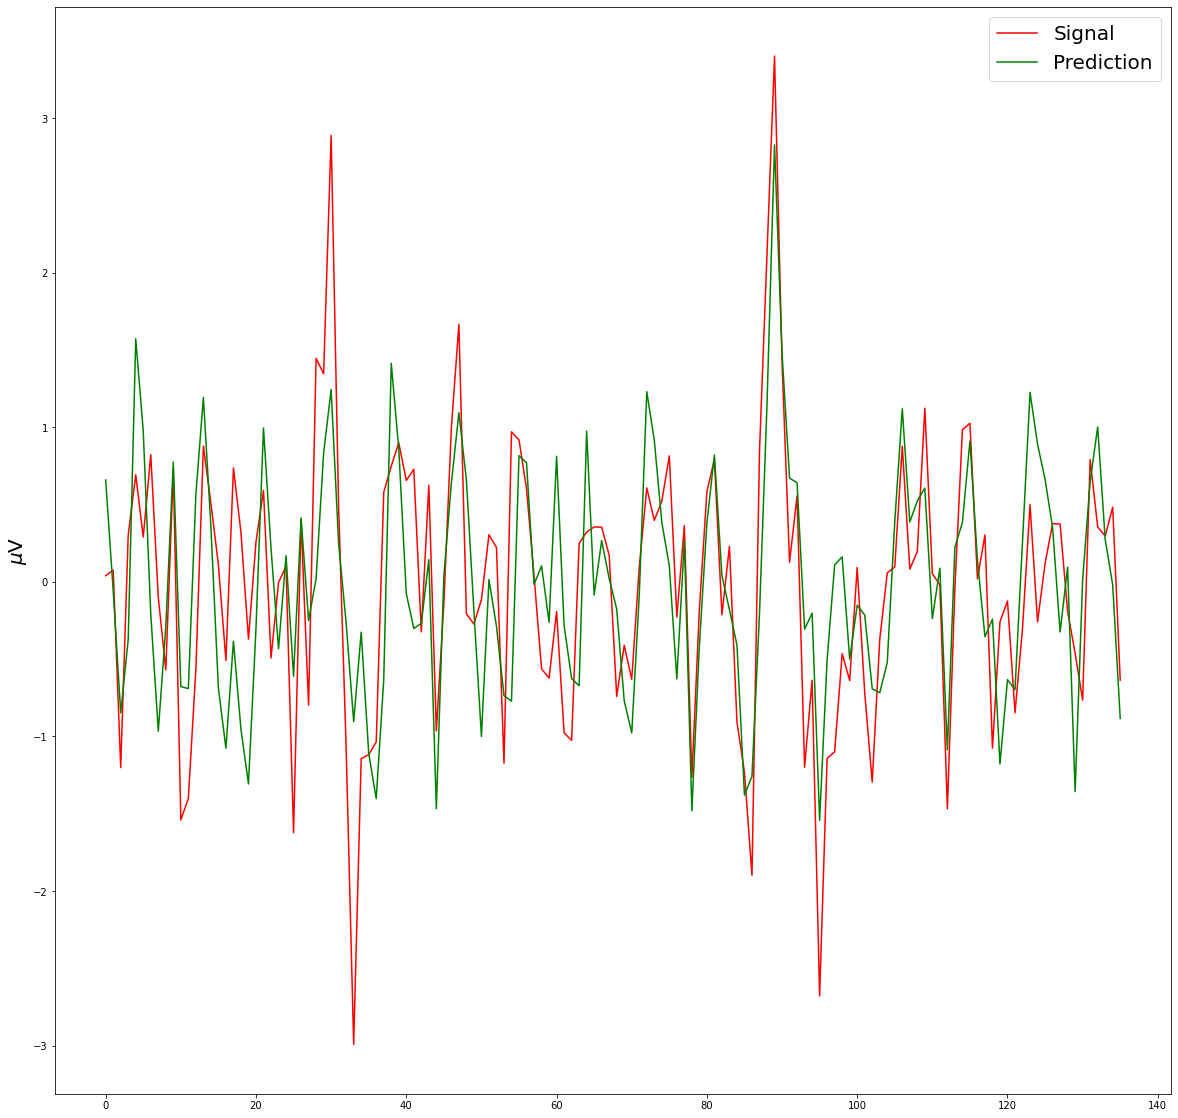

In [20]:
predictions = model.predict(X_test_1)
plt.figure(figsize = (20,20))
plt.plot(X_test_1[0], color = 'red', label='Signal')
plt.plot(predictions[0], color = 'green', label='Prediction')
plt.legend(fontsize=20)
plt.ylabel('$\mu$V', fontsize = 20)

## Model Selection

In [22]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier

#svc = svm.SVC(kernel='rbf')
#clf = MultiOutputClassifier(svc)
#clf = RandomForestClassifier(max_depth=100, random_state=0)
#clf = LinearDiscriminantAnalysis()
#clf = MLPClassifier(random_state=1, max_iter=3400)
clf = svm.SVC(kernel='rbf')
clf = clf.fit(np.hstack((intermediate_output,X_train)), y_train)

In [23]:
from sklearn.metrics import roc_curve

In [25]:
X_test_1_label = intermediate_layer_model.predict(X_test_1)

y_pred_1 = clf.predict(np.hstack((X_test_1_label,X_test_1)))

report_1 = classification_report(y_test_1, y_pred_1)  
print(report_1)

              precision    recall  f1-score   support

        -1.0       0.78      0.93      0.85        15
         1.0       0.92      0.73      0.81        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



In [26]:
X_test_2_label = intermediate_layer_model.predict(X_test_2)

y_pred_2 = clf.predict(np.hstack((X_test_2_label,X_test_2)))

report_2 = classification_report(y_test_2, y_pred_2)  
print(report_2)

              precision    recall  f1-score   support

        -1.0       0.87      0.87      0.87        15
         1.0       0.87      0.87      0.87        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30



In [27]:
X_test_3_label = intermediate_layer_model.predict(X_test_3)

y_pred_3 = clf.predict(np.hstack((X_test_3_label,X_test_3)))

report_3 = classification_report(y_test_3, y_pred_3)  
print(report_3)

              precision    recall  f1-score   support

        -1.0       0.62      0.53      0.57        15
         1.0       0.59      0.67      0.62        15

    accuracy                           0.60        30
   macro avg       0.60      0.60      0.60        30
weighted avg       0.60      0.60      0.60        30



In [28]:
X_test_4_label = intermediate_layer_model.predict(X_test_4)

y_pred_4 = clf.predict(np.hstack((X_test_4_label,X_test_4)))

report_4 = classification_report(y_test_4, y_pred_4)  
print(report_4)

              precision    recall  f1-score   support

        -1.0       0.75      1.00      0.86        15
         1.0       1.00      0.67      0.80        15

    accuracy                           0.83        30
   macro avg       0.88      0.83      0.83        30
weighted avg       0.88      0.83      0.83        30



In [29]:
X_test_5_label = intermediate_layer_model.predict(X_test_5)

y_pred_5 = clf.predict(np.hstack((X_test_5_label,X_test_5)))

report_5 = classification_report(y_test_5, y_pred_5)  
print(report_5)

              precision    recall  f1-score   support

        -1.0       0.85      0.73      0.79        15
         1.0       0.76      0.87      0.81        15

    accuracy                           0.80        30
   macro avg       0.81      0.80      0.80        30
weighted avg       0.81      0.80      0.80        30



## Final Score

We decleared that the third patient is an outlier. The model perform with a good score on 4 patients, but not on the third one.

So, we printed the mean of all the F1-Scores and Precision Scores. These is the score that our model can perform.

In [30]:
from sklearn.metrics import precision_recall_fscore_support as score

In [31]:
precision1,recall1,fscore1,support1 = score(y_test_1, y_pred_1,average='macro')
precision2,recall2,fscore2,support2 = score(y_test_2, y_pred_2,average='macro')
precision3,recall3,fscore3,support3 = score(y_test_3, y_pred_3,average='macro')
precision4,recall4,fscore4,support4 = score(y_test_4, y_pred_4,average='macro')
precision5,recall5,fscore5,support5 = score(y_test_5, y_pred_5,average='macro')

In [38]:
print("F1-Score : {}".format(
    (fscore1 + fscore2 + fscore4 + fscore5)/4))

print("Precision : {}".format(
    (precision1 + precision2 + precision4 + precision5)/4))

F1-Score : 0.8314987674362674
Precision : 0.8485796882855707
